In [1]:
# Import necessary libraries
import pandas as pd
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from sklearn.pipeline import make_pipeline
from joblib import dump

In [2]:
# Load and preprocess data
def load_preprocess_data(filepath):
    df = pd.read_excel(r"C:\Users\USER\PYTHON FOR DATASCIENCE UDEMY\YOUTUBE MACHINE LEARNING PROJECT\GEO_DATASCIENCE\Multi -element analysis sheet for Machine Learning.xlsx")
    df.set_index('Sample ID', inplace=True)
    df = df.replace('<', '', regex=True)
    df = df.drop(['Au_ppm','Lithology'], axis=1)
    df = df.replace({'AU_ppm': {'Yes': 1, 'No': 0}})
   # dummies = pd.get_dummies(df['Lithology'])
   # df = pd.concat([df, dummies], axis=1).drop(['Lithology', 'BMS'], axis=1)
    df.rename_axis(None, inplace=True)
  
    
    print("DataFrame shape after preprocessing:", df.shape)
    print("First few rows of the DataFrame:", df.head(), "\n")
    
    return df

In [3]:
df = load_preprocess_data(r"C:\Users\USER\PYTHON FOR DATASCIENCE UDEMY\YOUTUBE MACHINE LEARNING PROJECT\GEO_DATASCIENCE\Multi -element analysis sheet for Machine Learning.xlsx")

DataFrame shape after preprocessing: (2020, 36)
First few rows of the DataFrame:           AU_ppm Ag_ppm Al_pc As_ppm B_ppm Ba_ppm Be_ppm Bi_ppm Ca_pc Cd_ppm  \
DD005001       0    0.8  2.67      2    27     10    0.5     14  0.01    0.5   
DD005002       0    0.2   3.4      2    23     10    0.5     10  0.01    0.5   
DD005003       0    0.2  5.36      2    20     10    0.5     11  0.01    0.5   
DD005004       0    0.5  3.84      2    18     10    0.6      8  0.01    0.5   
DD005005       0    0.2  2.82      2    13     10    0.5      7  0.01    0.5   

          ... Sb_ppm Sc_ppm Sr_ppm Th_ppm Ti_pc Tl_ppm V_ppm W_ppm Zn_ppm  \
DD005001  ...      8     50      1      8  0.06     10   803    10     45   
DD005002  ...     12     68      1      8  0.05     10  1340    10     40   
DD005003  ...      6     77      1      8  0.05     10   995    10     49   
DD005004  ...      8     72      1      8  0.07     10   569    10    119   
DD005005  ...      6     48      1      8  0.11     1

In [8]:
# Split data into features and target

target = 'AU_ppm'
X= df.drop(columns='AU_ppm',axis =1)
y =df['AU_ppm']

print("X shape:", X.shape)
print("y shape:", y.shape)
    
    

X shape: (2020, 35)
y shape: (2020,)


In [10]:
from sklearn.decomposition import PCA

In [11]:

   # Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
pca = PCA(n_components=2)

# First, scale the training and test sets
X_train_scaled = scaler.fit_transform(X_train)  # Fit and transform the scaler on the training set
X_test_scaled = scaler.transform(X_test)        # Only transform the test set with the fitted scaler

# Then, apply PCA to the scaled training and test sets
X_train_pca = pca.fit_transform(X_train_scaled) # Fit and transform PCA on the scaled training set
X_test_pca = pca.transform(X_test_scaled) 

# Oversampling on the PCA-transformed training data
over_sampling = RandomOverSampler(random_state=42)
X_train_over, y_train_over = over_sampling.fit_resample(X_train_pca, y_train)

# Now, you use X_train_over and y_train_over for training with GridSearchCV
pipeline = make_pipeline(StandardScaler(), RandomForestClassifier(random_state=42))
param_grid = {
    'randomforestclassifier__n_estimators': [25, 50, 75],
    'randomforestclassifier__max_depth': [10, 20, 30, None]
}

model_over = GridSearchCV(pipeline, param_grid=param_grid, cv=5, n_jobs=-1, verbose=1)
model_over.fit(X_train_over, y_train_over)

# Evaluate the model on the PCA-transformed test set
y_pred = model_over.predict(X_test_pca)
accuracy = round(accuracy_score(y_test, y_pred) * 100, 2)

print(f"Best model accuracy: {accuracy}%")
print(f"Best parameters: {model_over.best_params_}")

Fitting 5 folds for each of 12 candidates, totalling 60 fits
Best model accuracy: 93.32%
Best parameters: {'randomforestclassifier__max_depth': 30, 'randomforestclassifier__n_estimators': 50}


              precision    recall  f1-score   support

           0       0.96      0.97      0.96       378
           1       0.47      0.35      0.40        26

    accuracy                           0.93       404
   macro avg       0.71      0.66      0.68       404
weighted avg       0.92      0.93      0.93       404



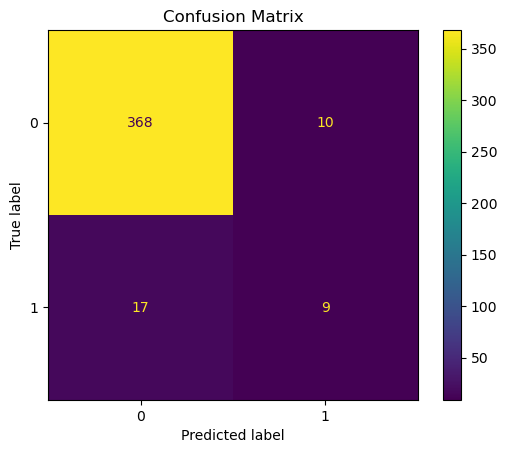

In [20]:
import matplotlib.pyplot as plt

# Printing the classification report
print(classification_report(y_test, y_pred))

    # Plotting the confusion matrix
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.title('Confusion Matrix')
plt.show()

In [23]:
#Lets Predict new values
import numpy as np

def make_prediction_with_interpretation(input_values, scaler, pca, model):
    
    # Convert the input to a 2D array for processing
    new_data = np.array(input_values).reshape(1, -1)
    
    # Apply the previously fitted scaler and PCA
    new_data_scaled = scaler.transform(new_data)
    new_data_pca = pca.transform(new_data_scaled)
    
    # Use the trained model to make a prediction
    prediction = model.predict(new_data_pca)
    
    # Interpret the prediction
    if prediction == 0:
        return "No gold present"
    else:
        return "Gold present"

# Assuming you've already defined 'scaler', 'pca', and 'model_over' from your trained models

input_values = [0.8, 2.67, 2, 27, 10, 0.5, 14, 0.01, 0.5, 7, 902, 78, 20.6, 37, 1, 0.01, 10, 0.02, 119, 2, 0.01, 21, 343, 14, 0.04, 8, 50, 1, 8, 0.06, 10, 803, 10, 45, 21]
message = make_prediction_with_interpretation(input_values, scaler, pca, model_over)
print(message)

No gold present


C:\Users\USER\AppData\Roaming\Python\Python311\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


In [25]:
from joblib import dump

# Save the objects
dump(scaler, 'scaler.joblib')
dump(pca, 'pca.joblib')
dump(model_over, 'Ramdom_Gold_model.joblib')

['Ramdom_Gold_model.joblib']

In [ ]:
from joblib import load
import streamlit as st
import numpy as np

# Load the scaler, PCA, and model
scaler = load('scaler.joblib')
pca = load('pca.joblib')
model_over = load('model_over.joblib')

# Streamlit app example
st.title('Gold Presence Prediction')

# Assuming you're taking input values through Streamlit's input methods
# This is a placeholder for where you'd collect or upload new data
input_values = st.text_input('Enter values separated by commas:')

if st.button('Predict'):
    # Process the input values
    input_list = list(map(float, input_values.split(',')))
    new_data = np.array(input_list).reshape(1, -1)
    
    # Scale, PCA transform, and predict
    new_data_scaled = scaler.transform(new_data)
    new_data_pca = pca.transform(new_data_scaled)
    prediction = model_over.predict(new_data_pca)
    
    # Display the prediction
    if prediction == 0:
        st.write("No gold present")
    else:
        st.write("Gold present")

pandas: For data manipulation and analysis.
scikit-learn (train_test_split, cross_val_score, GridSearchCV, accuracy_score, classification_report, confusion_matrix, StandardScaler, RandomForestClassifier, PCA): For various stages of the machine learning pipeline including splitting data, cross-validation, model evaluation metrics, preprocessing, and the machine learning model itself.
imbalanced-learn (RandomOverSampler, RandomUnderSampler): For handling imbalanced datasets by oversampling the minority class or undersampling the majority class.
matplotlib (plt): For creating visualizations, such as plotting the confusion matrix.
numpy: For numerical operations on arrays.
joblib: For saving and loading the trained machine learning models and preprocessing objects.